In [1]:
create_updated_files = True
create_report = False
install_pandas_profiling = False
from_drive = False

In [2]:
if from_drive:
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
if install_pandas_profiling:
    !pip install pandas-profiling==2.9.0

In [4]:
import pandas as pd
from collections import defaultdict
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

import warnings
warnings.filterwarnings("ignore")

if create_report:
    from pandas_profiling import ProfileReport

In [5]:
df1 = pd.read_csv("air_quality_merged.csv")
df2 = pd.read_csv("meteorological_data_merged.csv")

In [6]:
df2.head()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,H02,V02,H03,V03,H04,V04,H05,V05,H06,V06,H07,V07,H08,V08,H09,V09,H10,V10,H11,V11,H12,V12,H13,V13,H14,V14,H15,V15,H16,V16,H17,V17,H18,V18,H19,V19,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,102,81,28079102_81_98,2019,1,1,0.65,V,0.95,V,0.87,V,0.73,V,0.57,V,0.57,V,0.80,V,0.85,V,0.90,V,0.73,V,0.85,V,1.02,V,0.62,V,0.45,V,0.77,V,0.35,V,0.98,V,0.47,V,0.37,V,0.43,V,0.58,V,0.38,V,0.67,V,0.18,V
1,28,79,102,81,28079102_81_98,2019,1,2,0.50,V,0.95,V,0.60,V,0.73,V,1.62,V,1.42,V,0.48,V,2.42,V,0.75,V,1.35,V,1.40,V,0.98,V,0.83,V,0.47,V,0.52,V,0.50,V,0.57,V,0.80,V,0.88,V,0.53,V,1.13,V,2.02,V,3.48,V,2.82,V
2,28,79,102,81,28079102_81_98,2019,1,3,2.22,V,2.53,V,2.20,V,2.43,V,1.90,V,2.18,V,2.13,V,2.17,V,1.12,V,1.23,V,1.02,V,0.93,V,1.23,V,1.33,V,0.82,V,1.12,V,0.77,V,0.43,V,0.25,V,0.50,V,2.02,V,1.33,V,0.83,V,0.67,V
3,28,79,102,81,28079102_81_98,2019,1,4,0.87,V,0.77,V,0.87,V,0.92,V,0.65,V,0.47,V,0.70,V,0.23,V,0.50,V,0.78,V,1.03,V,0.87,V,0.45,V,0.50,V,0.48,V,0.28,V,0.68,V,0.47,V,0.40,V,0.13,V,0.58,V,0.92,V,0.20,V,0.33,V
4,28,79,102,81,28079102_81_98,2019,1,5,0.57,V,1.82,V,1.65,V,0.55,V,0.58,V,0.60,V,0.68,V,0.42,V,0.52,V,0.23,V,0.42,V,0.92,V,0.28,V,0.63,V,0.68,V,0.87,V,0.60,V,0.45,V,0.60,V,0.47,V,0.32,V,0.30,V,0.23,V,0.45,V


## Cleaning 

### Dropping columns with invalid data (N)

In [7]:
len(df1), len(df2)

(107523, 89943)

In [8]:
def drop_invalid_data(_df: pd.DataFrame):
    numbers = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
           "11", "12", "13", "14", "15", "16", "17", "18", "19", "20",
           "21", "22", "23", "24"]
           
    for num in numbers:
        _df = _df[_df["V" + num] == "V"]
    return _df

In [9]:
df1 = drop_invalid_data(df1)
df2 = drop_invalid_data(df2)

We have decided to drop this rows because there are just a few of them with invalid data. Furthermore, keeping them might generate outliers or noise since we are computing the mean of the day. This is because specially air polution probably varies during the day hours. For instance, NO_2 could reach his peak at 5 pm every day (we have not study it and it is not our goal with this project), thus removing that hour of the equation will result in a unusual low value for that day.

In [10]:
len(df1), len(df2)

(95278, 85168)

In [11]:
df1 = df1[[col for col in df1.columns if col[0] != "V"]]
df2 = df2[[col for col in df2.columns if col[0] != "V"]]

### PROVINCIA and MUNICIPIO have constant values 28 and 79 respectively, so we can drop them 

In [12]:
df1 = df1.drop(["PROVINCIA", "MUNICIPIO"], axis=1)
df2 = df2.drop(["PROVINCIA", "MUNICIPIO"], axis=1)

### Keeping just the needed values

In [13]:
df2 = df2[df2.MAGNITUD.isin({83, 89})]

## Transforming

### Adding a datetime column

In [14]:
df1 = df1.rename({"ANO": "year", "MES": "month", "DIA": "day"}, axis=1)
df2 = df2.rename({"ANO": "year", "MES": "month", "DIA": "day"}, axis=1)

In [15]:
df1["FECHA"] = pd.to_datetime(df1[["year", "month", "day"]])
df2["FECHA"] = pd.to_datetime(df2[["year", "month", "day"]])

In [16]:
df1.sort_values("FECHA", inplace=True)
df2.sort_values("FECHA", inplace=True)

In [17]:
df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

In [18]:
df1 = df1.rename({"year": "ANO", "month": "MES", "day": "DIA"}, axis=1)
df2 = df2.rename({"year": "ANO", "month": "MES", "day": "DIA"}, axis=1)

In [19]:
df1.head(3)

,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24,FECHA
0,4,1,28079004_1_38,2019,1,1,23.0,17.0,19.0,14.0,13.0,12.0,11.0,12.0,11.0,12.0,16.0,25.0,23.0,22.0,19.0,18.0,17.0,18.0,23.0,28.0,26.0,24.0,19.0,16.0,2019-01-01
1,36,8,28079036_8_8,2019,1,1,64.0,73.0,73.0,65.0,61.0,37.0,47.0,57.0,54.0,32.0,42.0,47.0,42.0,48.0,53.0,50.0,49.0,63.0,102.0,127.0,125.0,113.0,152.0,100.0,2019-01-01
2,36,7,28079036_7_8,2019,1,1,28.0,68.0,68.0,38.0,27.0,9.0,24.0,29.0,27.0,8.0,22.0,25.0,18.0,24.0,31.0,18.0,12.0,11.0,72.0,143.0,160.0,162.0,280.0,101.0,2019-01-01


### Change the values of MAGNITUD to a more readable information

In [20]:
# met_dict = {80:"UV Radiation(mW/m^2)",81:"Wind Velocity(m/s)",82:"Wind Direction(-)",83:"Temperature(ºC)",86:"Relative Humidity(%)",87:"Barometric Pressure(mb)",88:"Solar Radiation(W/m^2)",89:"Precipitation(l/m^2)"}
met_dict = {83:"Temperature(ºC)", 89:"Precipitation(l/m^2)"}
air_dict = {1:"SO_2(µg/m^3)",6:"CO(µg/m^3)",7:"NO(µg/m^3)",8:"NO_2(µg/m^3)",9:"PM2.5(µg/m^3)",10:"PM10(µg/m^3)",12:"NOx(µg/m^3)",14:"O_3(µg/m^3)",20:"TOL(µg/m^3)",30:"BEN(µg/m^3)",35:"EBE(µg/m^3)",37:"MXY(µg/m^3)",38:"PXY(µg/m^3)",39:"OXY(µg/m^3)",42:"TCH(mg/m^3)",43:"CH_4(mg/m^3)",44:"NMHC(mg/m^3)"}
df1.MAGNITUD = df1.MAGNITUD.map(air_dict)
df2.MAGNITUD = df2.MAGNITUD.map(met_dict)

In [21]:
df1.head(3)

,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24,FECHA
0,4,SO_2(µg/m^3),28079004_1_38,2019,1,1,23.0,17.0,19.0,14.0,13.0,12.0,11.0,12.0,11.0,12.0,16.0,25.0,23.0,22.0,19.0,18.0,17.0,18.0,23.0,28.0,26.0,24.0,19.0,16.0,2019-01-01
1,36,NO_2(µg/m^3),28079036_8_8,2019,1,1,64.0,73.0,73.0,65.0,61.0,37.0,47.0,57.0,54.0,32.0,42.0,47.0,42.0,48.0,53.0,50.0,49.0,63.0,102.0,127.0,125.0,113.0,152.0,100.0,2019-01-01
2,36,NO(µg/m^3),28079036_7_8,2019,1,1,28.0,68.0,68.0,38.0,27.0,9.0,24.0,29.0,27.0,8.0,22.0,25.0,18.0,24.0,31.0,18.0,12.0,11.0,72.0,143.0,160.0,162.0,280.0,101.0,2019-01-01


### Add CALLE column

Using the station code we have to assign the corresponding address which can be found in [interpretacion_calidad_del_aire](https://bit.ly/3czGpCF) and [interpretacion_de_datos_meteorologicos](
https://bit.ly/32eEtNM). The station code starts with 28079 and it is followed by the ESTACION number (with 3 digits: e.g. 4 -> 004). It can also be found in the prefix of PUNTO_MUESTREO.



In [22]:
calle_dict={1:"Paseo Recoletos", 2:"Glorieta Carlos V", 3:"Plaza del Carmen", 
            35:"Plaza del Carmen", 4:"Plaza de Espana", 5:"Barrio del Pilar", 
            39:"Barrio del Pilar", 6:"Plaza Doctor Maranon", 
            7:"Plaza Mayor de Salamanca", 8:"Escuelas Aguirre", 
            9:"Plaza Luca de Tena", 10: "Cuatro Caminos", 38:"Cuatro Caminos", 
            11:"Avenida Ramon y Cajal", 12:"Plaza Manuel Becerra", 13:"Vallecas", 
            40:"Vallecas", 14:"Plaza Fernandez Ladreda", 15:"Plaza Castilla", 
            50:"Plaza Castilla", 16:"Arturo Soria", 17:"Villaverde Alto", 
            18:"Farolillo", 19: "Huerta Castaneda", 20:"Moratalaz", 
            36:"Moratalaz", 102:"JMD Moratalaz", 21:"Plaza Cristo Rey", 
            22:"Paseo Pontones", 23:"Alcala", 24:"Casa de Campo", 
            25:"Santa Eugenia", 26:"Urbanizacion Embajada", 
            55:"Urbanizacion Embajada", 27:"Barajas", 47:"Mendez Alvaro", 
            48:"Paseo de la Castellana", 49:"Retiro", 54:"Ensanche de Vallecas", 
            56:"Plaza Eliptica", 57:"Sanchinarro", 58:"El Pardo", 
            59:"Parque Juan Carlos I", 86:"Tres Olivos", 60:"Tres Olivos", 
            103:"JMD Villaverde", 104:"EDAR La China", 
            106:"Centro Municipal de Acustica", 107:"JMD Hortaleza", 
            108:"Penagrande", 109:"JMD Chamberi", 110:"JMD Centro", 
            111:"JMD Chamartin", 112:"JMD Vallecas 1", 113:"JMD Vallecas 2", 
            114:"Matadero 1", 115:"Matadero 2"}

In [23]:
df1["CALLE"] = df1["ESTACION"].map(calle_dict)
df2["CALLE"] = df2["ESTACION"].map(calle_dict)
df1.head(10)

,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24,FECHA,CALLE
0,4,SO_2(µg/m^3),28079004_1_38,2019,1,1,23.00,17.0,19.00,14.00,13.00,12.00,11.00,12.00,11.0,12.00,16.00,25.0,23.00,22.00,19.00,18.00,17.00,18.00,23.00,28.00,26.00,24.00,19.0,16.00,2019-01-01,Plaza de Espana
1,36,NO_2(µg/m^3),28079036_8_8,2019,1,1,64.00,73.0,73.00,65.00,61.00,37.00,47.00,57.00,54.0,32.00,42.00,47.0,42.00,48.00,53.00,50.00,49.00,63.00,102.00,127.00,125.00,113.00,152.0,100.00,2019-01-01,Moratalaz
2,36,NO(µg/m^3),28079036_7_8,2019,1,1,28.00,68.0,68.00,38.00,27.00,9.00,24.00,29.00,27.0,8.00,22.00,25.0,18.00,24.00,31.00,18.00,12.00,11.00,72.00,143.00,160.00,162.00,280.0,101.00,2019-01-01,Moratalaz
3,56,NO(µg/m^3),28079056_7_8,2019,1,1,81.00,124.0,93.00,86.00,79.00,67.00,70.00,57.00,62.0,59.00,57.00,40.0,31.00,23.00,24.00,21.00,21.00,134.00,199.00,435.00,200.00,169.00,122.0,90.00,2019-01-01,Plaza Eliptica
4,36,CO(µg/m^3),28079036_6_48,2019,1,1,0.50,0.6,0.50,0.40,0.40,0.30,0.40,0.40,0.5,0.60,0.30,0.4,0.50,0.40,0.40,0.30,0.40,0.40,0.70,1.10,1.10,1.30,1.8,0.90,2019-01-01,Moratalaz
5,8,NO_2(µg/m^3),28079008_8_8,2019,1,1,79.00,76.0,85.00,81.00,68.00,50.00,55.00,56.00,58.0,51.00,41.00,43.0,45.00,59.00,56.00,57.00,61.00,72.00,88.00,99.00,103.00,103.00,135.0,110.00,2019-01-01,Escuelas Aguirre
6,36,SO_2(µg/m^3),28079036_1_38,2019,1,1,16.00,9.0,6.00,6.00,4.00,4.00,6.00,4.00,9.0,22.00,6.00,12.0,27.00,19.00,8.00,11.00,19.00,7.00,9.00,11.00,13.00,22.00,12.0,10.00,2019-01-01,Moratalaz
7,35,O_3(µg/m^3),28079035_14_6,2019,1,1,6.88,7.0,6.55,6.89,7.04,6.72,6.91,6.87,6.8,7.49,9.24,12.5,17.82,25.09,33.89,35.48,30.34,22.23,9.41,7.63,7.02,7.22,7.1,6.87,2019-01-01,Plaza del Carmen
8,56,NO_2(µg/m^3),28079056_8_8,2019,1,1,73.00,82.0,72.00,66.00,64.00,56.00,56.00,52.00,49.0,46.00,48.00,47.0,42.00,38.00,42.00,44.00,50.00,104.00,129.00,201.00,135.00,118.00,96.0,77.00,2019-01-01,Plaza Eliptica
9,35,NOx(µg/m^3),28079035_12_8,2019,1,1,230.00,236.0,264.00,339.00,276.00,199.00,203.00,165.00,170.0,170.00,137.00,143.0,139.00,107.00,80.00,73.00,77.00,80.00,111.00,178.00,180.00,298.00,385.0,290.00,2019-01-01,Plaza del Carmen


### Add MEDIDA column


In [24]:
df1["MEDIDA"] = df1["PUNTO_MUESTREO"] + df1["FECHA"].dt.strftime("_%y_%m_%d")
df2["MEDIDA"] = df2["PUNTO_MUESTREO"] + df2["FECHA"].dt.strftime("_%y_%m_%d")

In [25]:
df1.head()

,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24,FECHA,CALLE,MEDIDA
0,4,SO_2(µg/m^3),28079004_1_38,2019,1,1,23.0,17.0,19.0,14.0,13.0,12.0,11.0,12.0,11.0,12.0,16.0,25.0,23.0,22.0,19.0,18.0,17.0,18.0,23.0,28.0,26.0,24.0,19.0,16.0,2019-01-01,Plaza de Espana,28079004_1_38_19_01_01
1,36,NO_2(µg/m^3),28079036_8_8,2019,1,1,64.0,73.0,73.0,65.0,61.0,37.0,47.0,57.0,54.0,32.0,42.0,47.0,42.0,48.0,53.0,50.0,49.0,63.0,102.0,127.0,125.0,113.0,152.0,100.0,2019-01-01,Moratalaz,28079036_8_8_19_01_01
2,36,NO(µg/m^3),28079036_7_8,2019,1,1,28.0,68.0,68.0,38.0,27.0,9.0,24.0,29.0,27.0,8.0,22.0,25.0,18.0,24.0,31.0,18.0,12.0,11.0,72.0,143.0,160.0,162.0,280.0,101.0,2019-01-01,Moratalaz,28079036_7_8_19_01_01
3,56,NO(µg/m^3),28079056_7_8,2019,1,1,81.0,124.0,93.0,86.0,79.0,67.0,70.0,57.0,62.0,59.0,57.0,40.0,31.0,23.0,24.0,21.0,21.0,134.0,199.0,435.0,200.0,169.0,122.0,90.0,2019-01-01,Plaza Eliptica,28079056_7_8_19_01_01
4,36,CO(µg/m^3),28079036_6_48,2019,1,1,0.5,0.6,0.5,0.4,0.4,0.3,0.4,0.4,0.5,0.6,0.3,0.4,0.5,0.4,0.4,0.3,0.4,0.4,0.7,1.1,1.1,1.3,1.8,0.9,2019-01-01,Moratalaz,28079036_6_48_19_01_01


### Add mean_value column (mean of the day)

In [26]:
df1["meanValue"] = df1.loc[:,"H01": "H24"].mean(axis=1)
df2["meanValue"] = df1.loc[:,"H01": "H24"].mean(axis=1)

### Add max_value and min_value columns

In [27]:
df1["maxValue"] = df1.loc[:,"H01": "H24"].max(axis=1)
df2["maxValue"] = df1.loc[:,"H01": "H24"].max(axis=1)
df1["minValue"] = df1.loc[:,"H01": "H24"].min(axis=1)
df2["minValue"] = df1.loc[:,"H01": "H24"].min(axis=1)

In [28]:
df2.head()

,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24,FECHA,CALLE,MEDIDA,meanValue,maxValue,minValue
0,102,Temperature(ºC),28079102_83_98,2019,1,1,3.1,2.9,3.1,1.9,0.7,0.5,0.0,-0.8,0.0,2.2,3.1,5.5,7.8,10.1,10.4,11.9,10.1,8.5,7.7,7.1,6.6,5.8,4.1,3.4,2019-01-01,JMD Moratalaz,28079102_83_98_19_01_01,18.250000,28.0,11.0
1,58,Temperature(ºC),28079058_83_98,2019,1,1,-1.7,-2.2,-2.5,-2.8,-3.3,-3.5,-4.0,-4.4,-4.5,-2.0,-0.4,3.2,9.4,13.6,13.4,14.0,14.5,14.0,7.0,3.4,1.3,-0.1,-1.2,-1.8,2019-01-01,El Pardo,28079058_83_98_19_01_01,69.833333,152.0,32.0
2,103,Precipitation(l/m^2),28079103_89_98,2019,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-01,JMD Villaverde,28079103_89_98_19_01_01,58.541667,280.0,8.0
3,56,Precipitation(l/m^2),28079056_89_98,2019,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-01,Plaza Eliptica,28079056_89_98_19_01_01,97.666667,435.0,21.0
4,104,Temperature(ºC),28079104_83_98,2019,1,1,-0.8,-1.1,-1.4,-2.0,-2.9,-3.3,-3.6,-3.7,-3.5,-0.3,4.3,8.1,8.7,10.6,12.6,12.0,11.1,9.2,4.9,3.0,2.1,0.8,0.3,-0.6,2019-01-01,EDAR La China,28079104_83_98_19_01_01,0.608333,1.8,0.3


### Drop H columns

In [29]:
df1.drop(['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 
          'H13', 'H14',	'H15', 'H16', 'H17', 'H18',	'H19', 'H20', 'H21', 'H22', 'H23', 'H24'], axis=1, inplace=True)
df2.drop(['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 
          'H13', 'H14',	'H15', 'H16', 'H17', 'H18',	'H19', 'H20', 'H21', 'H22', 'H23', 'H24'], axis=1, inplace=True)

### Drop PUNTO_MUESTREO column

In [30]:
del df1["PUNTO_MUESTREO"]
del df2["PUNTO_MUESTREO"]

### Renaming columns

In [31]:
df1.rename(columns={'ESTACION':'ControlStation','MAGNITUD':'magnitude', 'ANO':'year', 'MES':'month', 'DIA':'day', 'FECHA':'date', 'CALLE':'stationName', 'MEDIDA':'Measurement'},inplace=True)

In [32]:
df2.rename(columns={'ESTACION':'ControlStation','MAGNITUD':'magnitude', 'ANO':'year', 'MES':'month', 'DIA':'day', 'FECHA':'date', 'CALLE':'stationName', 'MEDIDA':'Measurement'},inplace=True)

### Adding unit column

In [33]:
df1["unit"] = df1.magnitude.str.extract("\((.+)\)")
df2["unit"] = df2.magnitude.str.extract("\((.+)\)")

In [34]:
df1.magnitude = df1.magnitude.str.replace(r"\(.+\)", "")
df2.magnitude = df2.magnitude.str.replace(r"\(.+\)", "")

### Adding location_type column

In [35]:
def add_location_type(x: str):

    BUILDING = "Building"
    PARK = "Park"
    NEIGHBORHOOD = "Neighborhood"
    PLAZA = "Plaza"
    
    mapper = defaultdict(lambda: NEIGHBORHOOD)

    if "JMD" in x or "Matadero" in x:
        return BUILDING
    
    if "Plaza" in x:
        return PLAZA

    if "Parque" in x:
        return PARK

    mapper["El Pardo"] = BUILDING
    mapper["Casa de Campo"] = PARK
    mapper["EDAR La China"] = BUILDING
    mapper["Centro Municipal de Acústica"] = BUILDING
    mapper["Escuelas Aguirre"] = BUILDING
    mapper["Retiro"] = PARK
    mapper["Urbanizacion Embajada"] = BUILDING

    return mapper[x]

## Observations

Some stations measure both air quality and meteorological data:

In [36]:
set(df1.ControlStation.unique()) & set(df2.ControlStation.unique())

{4, 8, 18, 24, 35, 36, 38, 39, 54, 56, 58, 59}

There "Measurement" column has unique values

In [37]:
df1.Measurement.value_counts().unique()

array([1])

## Exporting data

### Creating an html report

In [38]:
if create_report:
    profile1 = ProfileReport(df1, title="Air Quality Data Report")

    profile1.to_file("air_quality_report.html")

In [39]:
if create_report:
    profile1 = ProfileReport(df2, title="Meteorological Data Report")

    profile1.to_file("meteorological_data_report.html")

### load dataframes into a csv file

In [40]:
df1

,ControlStation,magnitude,year,month,day,date,stationName,Measurement,meanValue,maxValue,minValue,unit
0,4,SO_2,2019,1,1,2019-01-01,Plaza de Espana,28079004_1_38_19_01_01,18.250000,28.0,11.0,µg/m^3
1,36,NO_2,2019,1,1,2019-01-01,Moratalaz,28079036_8_8_19_01_01,69.833333,152.0,32.0,µg/m^3
2,36,NO,2019,1,1,2019-01-01,Moratalaz,28079036_7_8_19_01_01,58.541667,280.0,8.0,µg/m^3
3,56,NO,2019,1,1,2019-01-01,Plaza Eliptica,28079056_7_8_19_01_01,97.666667,435.0,21.0,µg/m^3
4,36,CO,2019,1,1,2019-01-01,Moratalaz,28079036_6_48_19_01_01,0.608333,1.8,0.3,µg/m^3
...,...,...,...,...,...,...,...,...,...,...,...,...
95273,38,BEN,2021,8,31,2021-08-31,Cuatro Caminos,28079038_30_59_21_08_31,0.100000,0.1,0.1,µg/m^3
95274,50,NO_2,2021,8,31,2021-08-31,Plaza Castilla,28079050_8_8_21_08_31,24.666667,61.0,10.0,µg/m^3
95275,27,NOx,2021,8,31,2021-08-31,Barajas,28079027_12_8_21_08_31,34.291667,110.0,10.0,µg/m^3
95276,57,NOx,2021,8,31,2021-08-31,Sanchinarro,28079057_12_8_21_08_31,20.458333,54.0,10.0,µg/m^3


In [41]:
df2

,ControlStation,magnitude,year,month,day,date,stationName,Measurement,meanValue,maxValue,minValue,unit
0,102,Temperature,2019,1,1,2019-01-01,JMD Moratalaz,28079102_83_98_19_01_01,18.250000,28.0,11.00,ºC
1,58,Temperature,2019,1,1,2019-01-01,El Pardo,28079058_83_98_19_01_01,69.833333,152.0,32.00,ºC
2,103,Precipitation,2019,1,1,2019-01-01,JMD Villaverde,28079103_89_98_19_01_01,58.541667,280.0,8.00,l/m^2
3,56,Precipitation,2019,1,1,2019-01-01,Plaza Eliptica,28079056_89_98_19_01_01,97.666667,435.0,21.00,l/m^2
4,104,Temperature,2019,1,1,2019-01-01,EDAR La China,28079104_83_98_19_01_01,0.608333,1.8,0.30,ºC
...,...,...,...,...,...,...,...,...,...,...,...,...
30214,35,Temperature,2021,9,30,2021-09-30,Plaza del Carmen,28079035_83_98_21_09_30,9.875000,42.0,4.00,ºC
30215,112,Temperature,2021,9,30,2021-09-30,JMD Vallecas 1,28079112_83_98_21_09_30,0.266667,0.4,0.20,ºC
30216,108,Precipitation,2021,9,30,2021-09-30,Penagrande,28079108_89_98_21_09_30,10.375000,20.0,6.00,l/m^2
30217,39,Precipitation,2021,9,30,2021-09-30,Barrio del Pilar,28079039_89_98_21_09_30,78.738333,108.3,37.84,l/m^2


In [42]:
if create_updated_files:
    df1.to_csv("air_quality-updated.csv", index=False)
    df2.to_csv("meteorological_data-updated.csv", index=False)

## Plots

In [43]:
plt.style.use("bmh")

In [44]:
df1.magnitude.unique()

array(['SO_2', 'NO_2', 'NO', 'CO', 'O_3', 'NOx', 'PM2.5', 'PM10', 'NMHC',
       'CH_4', 'TCH', 'BEN', 'EBE', 'TOL'], dtype=object)

In [45]:
df1[df1.magnitude == 'NO'].iloc[0].unit

'µg/m^3'

In [46]:
def plot_air_quality_data(title, labels=None, years=(2019, 2020, 2021), figsize=(10, 6), bbox_to_anchor=None, compare_years=False, units=None):
    """
    Plots the data for the selected magnitudes
    Args:
        title (str): Title of the plot
        selected_labels (list): List of strings which contains the magnitude to be plotted.
        years (tuple): Tuple with the years to be plotted.
        figsize (tuple): Tuple with the size of the figure.
        compare_years (bool): If True, the data will be plotted for each year.
    """

    def get_magnitude(s):
        """
        Args:
            s (str): String with the magnitude.
        Returns:
            one magnitude contained from the string
        """
        for m in MAGNITUDES:
            if m in s:
                return m
        raise ValueError("Magnitude not found")


    def get_unit(m):
        return df1[df1.magnitude == m].iloc[0].unit
    

    MAGNITUDES = df1.magnitude.unique()
    UNITS = {get_unit(m) for m in MAGNITUDES}
    units = UNITS if units is None else units

    if bbox_to_anchor is None:
        bbox_to_anchor = (1.1, 1.05) if labels is None and "µg/m^3" in units else (1, 1)

    labels = [f"{m} ({get_unit(m)})" for m in MAGNITUDES if get_unit(m) in units] if labels is None else labels
    selected_magnitudes = [get_magnitude(s) for s in labels]
    dataframes = [df1[df1.magnitude == val][["date", "meanValue"]] for val in selected_magnitudes]

    fig = plt.figure(figsize=figsize)
    my_axes = fig.add_axes([0,0,1,1])
    my_axes.set_title(title)

    for df, magnitude, label in zip(dataframes, selected_magnitudes, labels):
        if not compare_years:
            temp = df[df1.date.dt.year.isin(years)].groupby("date").mean()
            my_axes.plot(temp.index, temp.meanValue, label=label)
        else:
            for year in years:

                raise NotImplementedError

                # we want to compare the values of each year by day with two different lines
                # the x-axis is the date and it shows the month, the y-axis is the average of the day

                temp = df[df1.date.dt.year == year].groupby("date").mean()

                temp["MONTH_DAY"] = temp.index.dt.strftime("%m-%d")

                # check if it is a leap year and drop the 29th of February using datetime
                if year % 4 == 0:
                    print(temp[temp.MONTH_DAY == "02-29"])
                    temp = temp[temp.MONTH_DAY != "02-29"]

                # my_axes.plot(pd.date_range("01-01", periods=365), temp.MEDIA_DIA, label=label + " " + str(year))

    my_axes.legend(loc=0, bbox_to_anchor=bbox_to_anchor)
    plt.show()

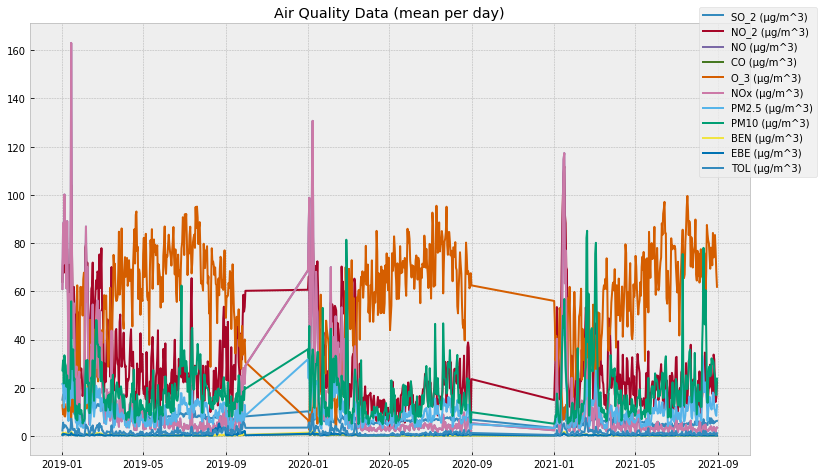

In [47]:
plot_air_quality_data("Air Quality Data (mean per day)", units={"µg/m^3"})

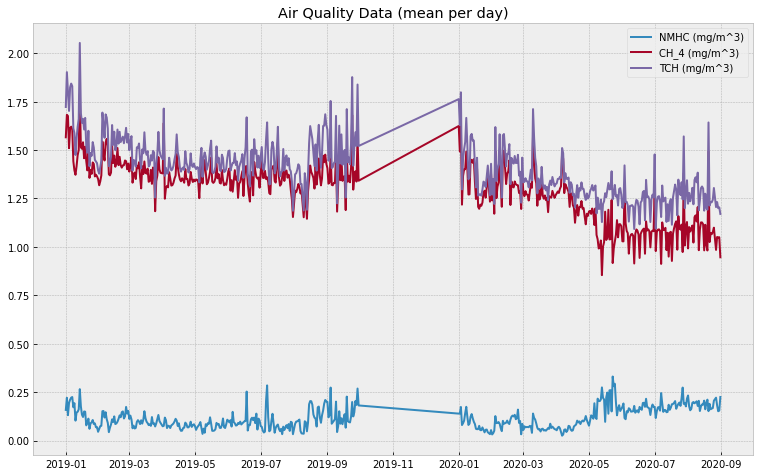

In [48]:
plot_air_quality_data("Air Quality Data (mean per day)", units={"mg/m^3"})

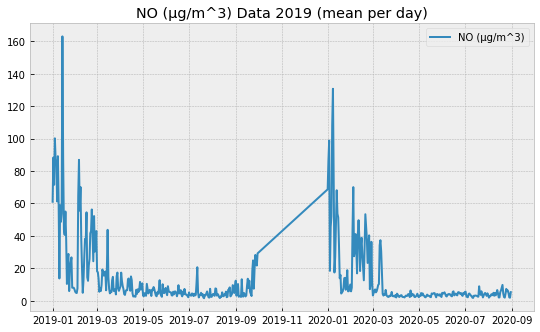

In [49]:
plot_air_quality_data("NO (µg/m^3) Data 2019 (mean per day)", ["NO (µg/m^3)"], [2019, 2020], figsize=(7, 4))

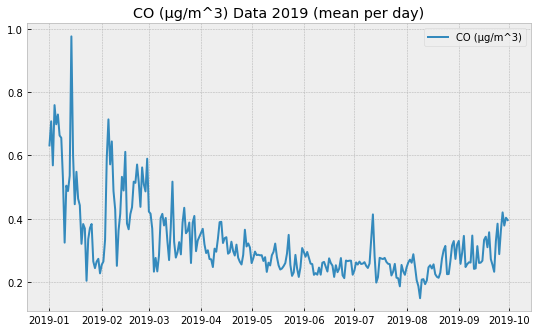

In [50]:
plot_air_quality_data("CO (µg/m^3) Data 2019 (mean per day)", ["CO (µg/m^3)"], [2019], figsize=(7, 4))

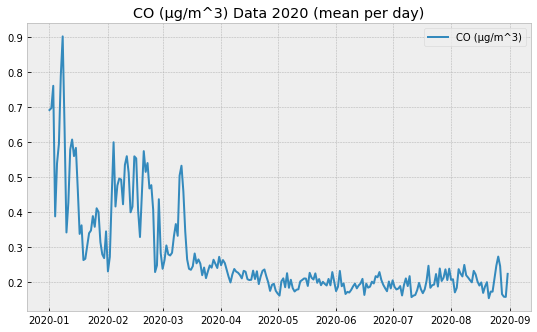

In [51]:
plot_air_quality_data("CO (µg/m^3) Data 2020 (mean per day)", ["CO (µg/m^3)"], [2020], figsize=(7, 4))

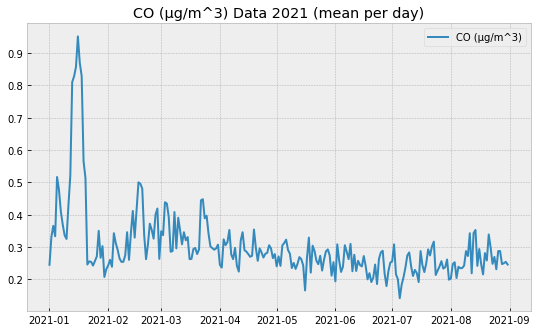

In [52]:
plot_air_quality_data("CO (µg/m^3) Data 2021 (mean per day)", ["CO (µg/m^3)"], [2021], figsize=(7, 4))